# Volatility Measure

Volatility is measured by the standard deviation over a specificed window. The ratio of volatility compared to something (like the DJI) is window independent and potential fits an f-distribution.

In [1]:
#packages needed for all models
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr

#Interactive plotting library
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

In [2]:
class Volatility():
    
    #start and end need to be datetime.datetime objects
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        
        # Check for valid inputs
        if len(self.ticker) < 1: #check for valid ticker
            print("\nInvalid ticker: length is less than 1 character\n")    
        if(type(end) != datetime.datetime or type(start) != datetime.datetime): #check dates are correct object
            print("\nInvalid date start and/or end object(s): datetime.datetime(yyyy,mm,dd) required for start and end dates\n")
        if start>end: #check end is after start
            print("\nInvalid dates: start date is after end date\n")
        
        # Read Dow Jones Industrial average file into pandas dataframe
        self.df_dow = pd.read_csv('^DJIdaily.csv')
        self.df_dow = self.df_dow.set_index(self.df_dow.Date) #index by date
        self.df_dow.index = pd.to_datetime(self.df_dow.index) #convert index into datetime object
        self.df_dow.head()

        # import Stock data
        self.df = pdr.get_data_quandl(self.ticker, start=start, end=end)
        self.df = self.df.reindex(index=self.df.index[::-1]) #reverse index to have oldest dates first

    def viewDFhead(self):
        return self.df.head()
    
    def viewDFtail(self):
        return self.df.tail()
    
    def viewDowDFhead(self):
        return self.df_dow.head()
    
    def viewDowDFtail(self):
        return self.df_dow.tail()
    
    def calcStockVolatility(self):
        #volitity NEEDS TO BE COMPARED TO SOMETHING (reason for DOW Jones Industrial average data)

        #calculate DJI and stock volatility
        daily_close_px_dow = self.df_dow[['Adj Close']]
        daily_close_px = self.df[['AdjClose']]

        # Calculate the daily percentage change for `daily_close_px`
        daily_pct_change_dow = daily_close_px_dow.pct_change()
        daily_pct_change = daily_close_px.pct_change()

        # Define the minumum of periods to consider (this variable changes the absolute volatility, but not the relative volatility)
        min_periods = 75

        # Calculate the volatility
        self.vol_dow = daily_pct_change_dow.rolling(min_periods).std() * np.sqrt(min_periods)
        self.vol_ticker = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 
        
    def plotVolatility(self):
        # Bohek plot (interactive)
        output_notebook()
        p = figure(title=self.ticker+' volatility comparison', x_axis_type='datetime', y_axis_label='Volatility')
        p.line(self.vol_ticker.index.values, self.vol_ticker['AdjClose'], color='blue', legend=self.ticker+' volatility')
        p.line(self.vol_dow.index.values, self.vol_dow['Adj Close'], color='red', legend='DJI volatility')
        p.legend.click_policy="hide"
        show(p)
        
    def calcVolComparisonMetrics(self):
        #Calculate difference between DJI volatility and ticker
        self.vol_diff = self.vol_ticker.join(self.vol_dow, how='inner') #join dow and ticker only inlcuding ticker dates
        self.vol_diff['Dif'] = self.vol_diff['AdjClose'] - self.vol_diff['Adj Close'] #'Adj Close is dow; AdjClose is ticker'
        self.vol_diff['Ratio'] = self.vol_diff['AdjClose']/self.vol_diff['Adj Close']
        
    def plotVolDiff(self):
        # Bohek plot (interactive)
        output_notebook()
        p = figure(title='Difference between '+ self.ticker+' and DJI volatility',x_axis_type='datetime',y_axis_label='Volatility')
        p.line((self.vol_diff).index.values,self.vol_diff['Dif'],color = 'blue',legend='Difference in Volatiltiy (ticker - DJI)')
        p.legend.click_policy="hide"
        show(p)
        
        self.vol_diff['Dif'].hist()
        print(self.vol_diff['Dif'].describe())
        
    def plotVolRatio(self):
        # Bohek plot (interactive)
        output_notebook()
        p = figure(title='Ratio between '+self.ticker+' and DJI',x_axis_type='datetime',y_axis_label='Volatility Ratio')
        p.line(self.vol_diff.index.values,self.vol_diff['Ratio'],color='blue',legend='Volatility Ratio (ticker/DJI)')
        p.legend.click_policy="hide"
        show(p)

        self.vol_diff['Ratio'].hist()
        print(self.vol_diff['Ratio'].describe())
        
    def getDiff(self):
        return self.vol_diff['Dif']
        
    def getRatio(self):
        return self.vol_diff['Ratio']

In [3]:
ticker = 'MSFT'
start = datetime.datetime(2015, 6, 19)
end = datetime.datetime(2018, 6, 1)
vol = Volatility(ticker, start, end)
vol.viewDFhead()
vol.calcStockVolatility()
vol.plotVolatility()

Loading BokehJS ...

Loading BokehJS ...

/Users/Razander/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    622.000000
mean       0.049899
std        0.015505
min        0.019076
25%             NaN
50%             NaN
75%             NaN
max        0.081143
Name: Dif, dtype: float64


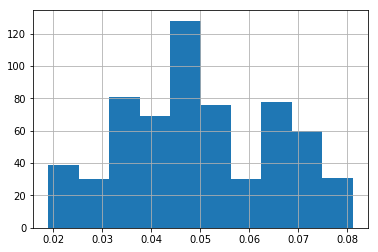

In [4]:
vol.calcVolComparisonMetrics()
vol.plotVolDiff()

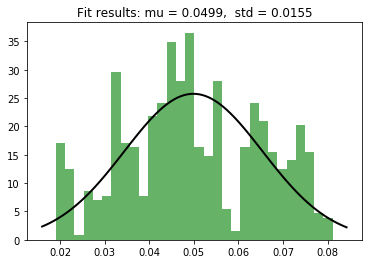

In [5]:
# Test fit to normal distribution
data = vol.getDiff().dropna()

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.4f,  std = %.4f" % (mu, std)
plt.title(title)

plt.show()

Loading BokehJS ...

/Users/Razander/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    622.000000
mean       1.930758
std        0.405793
min        1.274247
25%             NaN
50%             NaN
75%             NaN
max        3.169413
Name: Ratio, dtype: float64


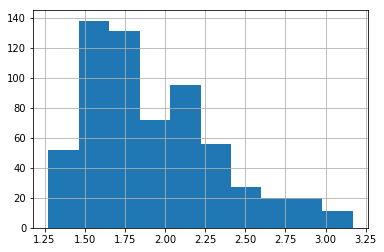

In [6]:
vol.plotVolRatio()

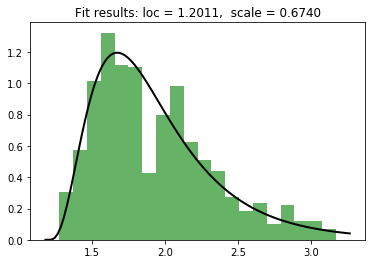

In [7]:
# Test fit to f-distribution
data = vol.getRatio().dropna()

# Fit a normal distribution to the data:
df1, df2, loc, scale = stats.f.fit(data, 2, 1, loc=0, scale=1)

# Plot the histogram.
plt.hist(data, bins=20, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.f.pdf(x, df1, df2,loc,scale)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: loc = %.4f,  scale = %.4f" % (loc, scale)
plt.title(title)

plt.show()